Part 3 concerns non symmetric distributions, such as chi-squared distributed errors. They are of interest because they are non-symmetric and positive.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

https://en.wikipedia.org/wiki/Skew_normal_distribution

Also, the previous functions are refactored. A more general function is used here.

In [211]:
import numpy as np
import matplotlib.pyplot as plt

In [212]:
iterations = 10000
n = 30
secret_beta = 2

It is good to refactor everything into functions! Avoid repeated code!

In [213]:
var_u_list = [0, 1.5, 2, 2.5,3.0,4.5,6.0,8.0,10.0]
var_eps_list = [1.5, 2, 2.5]

def experiment(distribution_label, gen_err_u, gen_err_eps):
    print(f"{distribution_label} distributed epsilon")
    
    beta_dict = {}
    sigma_dict = {}

    for var_u in var_u_list:
        for var_eps in var_eps_list:
            bias_beta = np.array([])
            sqerr_beta = np.array([])
            bias_beta_adj = np.array([])
            sqerr_beta_adj = np.array([])

            bias_sigma = np.array([])
            sqerr_sigma = np.array([])
            bias_sigma_adj_v2 = np.array([])
            sqerr_sigma_adj_v2 = np.array([])

            for _ in range(iterations):
                x = np.linspace(-20,20,n)
                if var_u > 0:
                    x_obs = x + gen_err_u(var_u, n)
                else:
                    x_obs = x
                y = x*secret_beta + gen_err_x(var_eps, n)

                beta_est = np.cov(x_obs, y, ddof=0)[0][1]/np.var(x_obs, ddof=0)
                beta_est_adj = np.cov(x_obs, y, ddof=1)[0][1]/(np.var(x_obs, ddof=1) - var_u)
                
                vx = np.var(x_obs, ddof=0) - var_u
                vu = var_u
                l = vx/(vx+vu);

                sigma_est = np.sum((y - beta_est * x_obs) ** 2) / (n-1)
#                 sigma_est_adj_v2 = np.var(y, ddof=0) - (beta_est_adj ** 2) *  vx
                sigma_est_adj_v2 = np.sum((y - beta_est * x_obs) ** 2) / (n-1) - (1-l)**2*beta_est_adj**2*vx - l**2*beta_est_adj**2*vu
                
#                 print(sigma_est_adj_v2, np.sum((y - beta_est_adj * x_obs) ** 2) / (n-1) - beta_est_adj ** 2 * vu)

                bias_beta = np.append(bias_beta, (beta_est-secret_beta))
                sqerr_beta = np.append(sqerr_beta, (beta_est-secret_beta)**2)
                bias_beta_adj = np.append(bias_beta_adj, (beta_est_adj-secret_beta))
                sqerr_beta_adj = np.append(sqerr_beta_adj, (beta_est_adj-secret_beta)**2)

                bias_sigma = np.append(bias_sigma, sigma_est-var_eps)
                sqerr_sigma = np.append(sqerr_sigma, (sigma_est-var_eps)**2)
                bias_sigma_adj_v2 = np.append(bias_sigma_adj_v2, sigma_est_adj_v2-var_eps)
                sqerr_sigma_adj_v2 = np.append(sqerr_sigma_adj_v2, (sigma_est_adj_v2-var_eps)**2)

            print("var_u=%.2f, var_eps=%.2f:  OLS: MBE = %f, MSE = %f; Sigma MBE = %f, MSE = %f"%(var_u, var_eps, bias_beta.mean(), sqerr_beta.mean(), bias_sigma.mean(), sqerr_sigma.mean()))

            print("var_u=%.2f, var_eps=%.2f:  MME: MBE = %f, MSE = %f; Sigma MBE = %f, MSE = %f"%(var_u, var_eps, bias_beta_adj.mean(), sqerr_beta_adj.mean(), bias_sigma_adj_v2.mean(), sqerr_sigma_adj_v2.mean()))
        
            beta_dict[(var_u, var_eps)] = {}
            beta_dict[(var_u, var_eps)]['bias_ols'] = bias_beta.mean()
            beta_dict[(var_u, var_eps)]['sqerr_ols'] = sqerr_beta.mean()
            beta_dict[(var_u, var_eps)]['bias_ols_corr'] = bias_beta_adj.mean()
            beta_dict[(var_u, var_eps)]['sqerr_ols_corr'] = sqerr_beta_adj.mean()
            
            sigma_dict[(var_u, var_eps)] = {}
            sigma_dict[(var_u, var_eps)]['bias_ols'] = bias_sigma.mean()
            sigma_dict[(var_u, var_eps)]['sqerr_ols'] = sqerr_sigma.mean()
            sigma_dict[(var_u, var_eps)]['bias_ols_corr_v2'] = bias_sigma_adj_v2.mean()
            sigma_dict[(var_u, var_eps)]['sqerr_ols_corr_v2'] = sqerr_sigma_adj_v2.mean()
            
        
    return beta_dict, sigma_dict

In [214]:
def show_plot(title, dicts, x_label, key1, key2, y_min, y_max):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(len(var_u_list), len(var_eps_list), figsize=(15,30))

    for i in range(len(var_u_list)):
        for j in range(len(var_eps_list)):
            labels = x_label
            vals1 = [ d[(var_u_list[i], var_eps_list[j])][key1] for d in dicts]
            vals2 = [ d[(var_u_list[i], var_eps_list[j])][key2] for d in dicts]
            
            x = np.arange(len(labels))  # the label locations
            width = 0.35  # the width of the bars
            
            axs[i,j].set_title(title + ': $\\sigma^2_u=%.2f$, $\\sigma^2_\\epsilon=%.2f$'%(var_u_list[i], var_eps_list[j]))
            axs[i,j].bar(x - width/2, vals1, width, label="OLS")
            axs[i,j].bar(x + width/2, vals2, width, label="MME")
            axs[i,j].set_xticks(x)
            axs[i,j].set_xticklabels(labels)
            axs[i,j].legend()
            
            # axs[i,j].bar(x_label,vals,color=['tab:blue', 'tab:orange', 'tab:green'][:len(dicts)])
            axs[i][j].set_ylim(y_min, y_max)
            
    plt.subplots_adjust(hspace=0.3)

    plt.show()

Perform experiments

In [215]:
def gen_err_x(var, n):
    return np.random.normal(scale=np.sqrt(var), size=n)

def gen_err_eps(var, n):
    return np.random.normal(scale=np.sqrt(var), size=n)

beta_dict_normal, sigma_dict_normal = experiment("Normal", gen_err_x, gen_err_eps)

Normal distributed epsilon
var_u=0.00, var_eps=1.50:  OLS: MBE = -0.000030, MSE = 0.000345; Sigma MBE = 0.000984, MSE = 0.158379
var_u=0.00, var_eps=1.50:  MME: MBE = -0.000030, MSE = 0.000345; Sigma MBE = 0.000984, MSE = 0.158379
var_u=0.00, var_eps=2.00:  OLS: MBE = -0.000037, MSE = 0.000466; Sigma MBE = 0.004837, MSE = 0.284930
var_u=0.00, var_eps=2.00:  MME: MBE = -0.000037, MSE = 0.000466; Sigma MBE = 0.004837, MSE = 0.284930
var_u=0.00, var_eps=2.50:  OLS: MBE = 0.000066, MSE = 0.000580; Sigma MBE = 0.007782, MSE = 0.440205
var_u=0.00, var_eps=2.50:  MME: MBE = 0.000066, MSE = 0.000580; Sigma MBE = 0.007782, MSE = 0.440205
var_u=1.50, var_eps=1.50:  OLS: MBE = -0.018939, MSE = 0.002037; Sigma MBE = 5.932792, MSE = 39.038672
var_u=1.50, var_eps=1.50:  MME: MBE = 0.001253, MSE = 0.001770; Sigma MBE = -0.014604, MSE = 3.906280
var_u=1.50, var_eps=2.00:  OLS: MBE = -0.019086, MSE = 0.002144; Sigma MBE = 5.935520, MSE = 39.577181
var_u=1.50, var_eps=2.00:  MME: MBE = 0.001096, MSE = 0

In [216]:
def gen_table(d, field_1, field_2):
    for var_u in var_u_list:
        if var_u == 0:
            continue
        print("$\sigma^2_u = %.1f$"%var_u, end="")
        for var_eps in var_eps_list:
            print("&%.6f"%d[(var_u, var_eps)][field_1], end="")
            print("&%.6f"%d[(var_u, var_eps)][field_2], end="")
            
        print(r"\\")

In [217]:
def gen_table2(d1, d2, field_1, field_2):
    for var_u in var_u_list:
        if var_u == 0:
            continue
        print("$\sigma^2_u = %.1f$"%var_u, end="")
        for var_eps in var_eps_list:
            print("&%.6f"%(d2[(var_u, var_eps)][field_1]-d1[(var_u, var_eps)][field_1]), end="")
            print("&%.6f"%(d2[(var_u, var_eps)][field_2]-d1[(var_u, var_eps)][field_2]), end="")
            
        print(r"\\")

In [218]:
gen_table(beta_dict_normal, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.018939&0.001253&-0.019086&0.001096&-0.018936&0.001263\\
$\sigma^2_u = 2.0$&-0.024037&0.002867&-0.024948&0.001922&-0.026092&0.000734\\
$\sigma^2_u = 2.5$&-0.030818&0.002706&-0.031524&0.001964&-0.031156&0.002337\\
$\sigma^2_u = 3.0$&-0.036164&0.003996&-0.036940&0.003187&-0.037441&0.002643\\
$\sigma^2_u = 4.5$&-0.055692&0.003997&-0.054567&0.005233&-0.054410&0.005415\\
$\sigma^2_u = 6.0$&-0.072322&0.006878&-0.072668&0.006455&-0.072209&0.006979\\
$\sigma^2_u = 8.0$&-0.095547&0.009051&-0.096337&0.008116&-0.096248&0.008270\\
$\sigma^2_u = 10.0$&-0.117944&0.011709&-0.118315&0.011246&-0.119311&0.010030\\


In [219]:
gen_table(beta_dict_normal, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.002037&0.001770&0.002144&0.001873&0.002294&0.002033\\
$\sigma^2_u = 2.0$&0.002761&0.002355&0.002883&0.002429&0.003006&0.002490\\
$\sigma^2_u = 2.5$&0.003551&0.002859&0.003658&0.002917&0.003675&0.002956\\
$\sigma^2_u = 3.0$&0.004215&0.003267&0.004421&0.003419&0.004594&0.003560\\
$\sigma^2_u = 4.5$&0.007201&0.004877&0.007307&0.005151&0.007363&0.005224\\
$\sigma^2_u = 6.0$&0.010440&0.006606&0.010633&0.006762&0.010708&0.006925\\
$\sigma^2_u = 8.0$&0.015678&0.008987&0.015807&0.008913&0.015952&0.009115\\
$\sigma^2_u = 10.0$&0.021516&0.011299&0.022037&0.011917&0.022233&0.011787\\


In [220]:
gen_table(sigma_dict_normal, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&5.932792&-0.014604&5.935520&-0.011125&5.923353&-0.024472\\
$\sigma^2_u = 2.0$&7.929682&0.013693&7.913429&0.004663&7.896292&-0.003343\\
$\sigma^2_u = 2.5$&9.839682&-0.020557&9.842957&-0.010262&9.791586&-0.065408\\
$\sigma^2_u = 3.0$&11.774732&-0.032705&11.747432&-0.051048&11.692577&-0.100115\\
$\sigma^2_u = 4.5$&17.461051&-0.074158&17.509245&-0.047976&17.495570&-0.064985\\
$\sigma^2_u = 6.0$&23.064790&-0.148927&23.028163&-0.177443&22.967193&-0.250856\\
$\sigma^2_u = 8.0$&30.338040&-0.273844&30.400640&-0.184114&30.502265&-0.087665\\
$\sigma^2_u = 10.0$&37.448041&-0.414920&37.391793&-0.460250&37.432010&-0.376640\\


In [221]:
gen_table(sigma_dict_normal, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&39.038672&3.906280&39.577181&4.402046&39.998554&4.988450\\
$\sigma^2_u = 2.0$&69.163944&6.381618&69.249301&6.762670&69.922998&7.695284\\
$\sigma^2_u = 2.5$&105.985146&9.461604&106.813807&10.203495&106.353054&10.768791\\
$\sigma^2_u = 3.0$&151.061647&12.833555&151.073663&13.462730&150.496342&14.220774\\
$\sigma^2_u = 4.5$&329.950808&26.616059&333.092969&28.083111&333.675530&28.960378\\
$\sigma^2_u = 6.0$&573.848452&45.117987&573.448511&46.438989&571.889960&47.388250\\
$\sigma^2_u = 8.0$&991.312756&78.713241&997.106638&80.410267&1003.416775&80.874677\\
$\sigma^2_u = 10.0$&1505.947241&118.030262&1501.768479&117.703199&1510.174585&122.894751\\


In [222]:
def gen_err_x(var, n):
    return np.random.standard_t(df=2*var/(var-1), size=n) # var=df/(df-2)

def gen_err_eps(var, n):
    return np.random.standard_t(df=2*var/(var-1), size=n)

beta_dict_t, sigma_dict_t = experiment("Student-T", gen_err_x, gen_err_eps)

Student-T distributed epsilon
var_u=0.00, var_eps=1.50:  OLS: MBE = 0.000130, MSE = 0.000354; Sigma MBE = 0.004515, MSE = 0.393766
var_u=0.00, var_eps=1.50:  MME: MBE = 0.000130, MSE = 0.000354; Sigma MBE = 0.004515, MSE = 0.393766
var_u=0.00, var_eps=2.00:  OLS: MBE = -0.000278, MSE = 0.000469; Sigma MBE = -0.015283, MSE = 1.499630
var_u=0.00, var_eps=2.00:  MME: MBE = -0.000278, MSE = 0.000469; Sigma MBE = -0.015283, MSE = 1.499630
var_u=0.00, var_eps=2.50:  OLS: MBE = -0.000021, MSE = 0.000580; Sigma MBE = -0.033809, MSE = 7.737917
var_u=0.00, var_eps=2.50:  MME: MBE = -0.000021, MSE = 0.000580; Sigma MBE = -0.033809, MSE = 7.737917
var_u=1.50, var_eps=1.50:  OLS: MBE = -0.018534, MSE = 0.002062; Sigma MBE = 5.939857, MSE = 42.539382
var_u=1.50, var_eps=1.50:  MME: MBE = 0.001674, MSE = 0.001813; Sigma MBE = -0.010067, MSE = 7.429951
var_u=1.50, var_eps=2.00:  OLS: MBE = -0.018430, MSE = 0.002187; Sigma MBE = 5.975117, MSE = 46.301052
var_u=1.50, var_eps=2.00:  MME: MBE = 0.001775, 

In [223]:
gen_table(beta_dict_t, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.018534&0.001674&-0.018430&0.001775&-0.018701&0.001499\\
$\sigma^2_u = 2.0$&-0.025268&0.001583&-0.024598&0.002281&-0.025165&0.001681\\
$\sigma^2_u = 2.5$&-0.031360&0.002123&-0.030793&0.002724&-0.031042&0.002462\\
$\sigma^2_u = 3.0$&-0.035362&0.004831&-0.036552&0.003600&-0.035890&0.004256\\
$\sigma^2_u = 4.5$&-0.047345&0.012872&-0.047708&0.012559&-0.047700&0.012533\\
$\sigma^2_u = 6.0$&-0.054332&0.026307&-0.054005&0.026703&-0.055288&0.025295\\
$\sigma^2_u = 8.0$&-0.061691&0.046731&-0.061276&0.047069&-0.062339&0.046046\\
$\sigma^2_u = 10.0$&-0.065760&0.071138&-0.065444&0.071461&-0.066481&0.070254\\


In [224]:
gen_table(beta_dict_t, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.002062&0.001813&0.002187&0.001947&0.002345&0.002096\\
$\sigma^2_u = 2.0$&0.003014&0.002549&0.003544&0.003133&0.003215&0.002760\\
$\sigma^2_u = 2.5$&0.004272&0.003574&0.004312&0.003650&0.004744&0.004084\\
$\sigma^2_u = 3.0$&0.005649&0.004841&0.006056&0.005177&0.005358&0.004496\\
$\sigma^2_u = 4.5$&0.009982&0.008939&0.011126&0.010153&0.011052&0.010029\\
$\sigma^2_u = 6.0$&0.012857&0.012377&0.013294&0.012892&0.014145&0.013602\\
$\sigma^2_u = 8.0$&0.017909&0.019432&0.016567&0.018007&0.019584&0.021246\\
$\sigma^2_u = 10.0$&0.019067&0.024097&0.019324&0.024493&0.020736&0.025816\\


In [227]:
gen_table2(beta_dict_normal, beta_dict_t, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&0.000405&0.000421&0.000656&0.000679&0.000235&0.000236\\
$\sigma^2_u = 2.0$&-0.001232&-0.001284&0.000350&0.000360&0.000927&0.000947\\
$\sigma^2_u = 2.5$&-0.000542&-0.000583&0.000731&0.000760&0.000114&0.000125\\
$\sigma^2_u = 3.0$&0.000802&0.000835&0.000388&0.000412&0.001551&0.001613\\
$\sigma^2_u = 4.5$&0.008347&0.008875&0.006859&0.007327&0.006709&0.007118\\
$\sigma^2_u = 6.0$&0.017989&0.019429&0.018663&0.020248&0.016920&0.018316\\
$\sigma^2_u = 8.0$&0.033856&0.037680&0.035061&0.038953&0.033909&0.037775\\
$\sigma^2_u = 10.0$&0.052184&0.059429&0.052870&0.060215&0.052830&0.060224\\


In [228]:
gen_table2(beta_dict_normal, beta_dict_t, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.000025&0.000043&0.000044&0.000074&0.000051&0.000062\\
$\sigma^2_u = 2.0$&0.000254&0.000195&0.000661&0.000704&0.000209&0.000270\\
$\sigma^2_u = 2.5$&0.000721&0.000714&0.000654&0.000733&0.001069&0.001128\\
$\sigma^2_u = 3.0$&0.001434&0.001574&0.001635&0.001757&0.000764&0.000936\\
$\sigma^2_u = 4.5$&0.002780&0.004061&0.003819&0.005002&0.003689&0.004805\\
$\sigma^2_u = 6.0$&0.002417&0.005770&0.002661&0.006129&0.003437&0.006677\\
$\sigma^2_u = 8.0$&0.002231&0.010445&0.000761&0.009094&0.003632&0.012131\\
$\sigma^2_u = 10.0$&-0.002450&0.012798&-0.002714&0.012576&-0.001497&0.014030\\


In [225]:
gen_table(sigma_dict_t, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&5.939857&-0.010067&5.975117&0.024385&5.916221&-0.033102\\
$\sigma^2_u = 2.0$&7.920324&0.013937&7.982715&0.069748&7.857677&-0.049926\\
$\sigma^2_u = 2.5$&9.692796&-0.163624&9.569967&-0.292431&9.789660&-0.071267\\
$\sigma^2_u = 3.0$&11.190537&-0.631216&11.299564&-0.508791&11.079149&-0.735047\\
$\sigma^2_u = 4.5$&14.621853&-3.083331&15.214555&-2.489814&14.842164&-2.861617\\
$\sigma^2_u = 6.0$&16.898038&-6.787604&17.143535&-6.553582&17.244694&-6.424922\\
$\sigma^2_u = 8.0$&19.557953&-12.242632&19.120280&-12.681435&19.679398&-12.113792\\
$\sigma^2_u = 10.0$&20.838239&-19.291314&20.711561&-19.433986&20.775767&-19.338911\\


In [226]:
gen_table(sigma_dict_t, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&42.539382&7.429951&46.301052&10.725321&48.728409&13.863712\\
$\sigma^2_u = 2.0$&92.267768&30.865699&129.441842&68.036523&106.079800&45.725720\\
$\sigma^2_u = 2.5$&181.355242&92.219580&183.868318&96.655826&234.088113&144.524988\\
$\sigma^2_u = 3.0$&314.645580&200.552759&325.564362&209.926358&269.471675&155.865314\\
$\sigma^2_u = 4.5$&629.449790&465.167108&769.628382&594.519735&719.903966&552.996711\\
$\sigma^2_u = 6.0$&862.719161&703.193438&923.948721&754.746573&969.868912&799.358438\\
$\sigma^2_u = 8.0$&1385.532062&1321.162591&1234.438194&1183.074585&1475.251005&1419.790703\\
$\sigma^2_u = 10.0$&1512.720688&1686.826202&1498.622973&1687.819564&1666.798454&1869.322225\\


In [229]:
gen_table2(sigma_dict_normal, sigma_dict_t, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&0.007065&0.004538&0.039597&0.035510&-0.007132&-0.008629\\
$\sigma^2_u = 2.0$&-0.009358&0.000244&0.069285&0.065085&-0.038615&-0.046583\\
$\sigma^2_u = 2.5$&-0.146886&-0.143067&-0.272990&-0.282169&-0.001926&-0.005859\\
$\sigma^2_u = 3.0$&-0.584195&-0.598510&-0.447868&-0.457743&-0.613427&-0.634932\\
$\sigma^2_u = 4.5$&-2.839198&-3.009174&-2.294690&-2.441837&-2.653406&-2.796632\\
$\sigma^2_u = 6.0$&-6.166752&-6.638677&-5.884628&-6.376139&-5.722498&-6.174067\\
$\sigma^2_u = 8.0$&-10.780087&-11.968787&-11.280360&-12.497321&-10.822867&-12.026126\\
$\sigma^2_u = 10.0$&-16.609802&-18.876395&-16.680233&-18.973736&-16.656243&-18.962271\\


In [230]:
gen_table2(sigma_dict_normal, sigma_dict_t, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&3.500710&3.523671&6.723871&6.323275&8.729855&8.875262\\
$\sigma^2_u = 2.0$&23.103823&24.484081&60.192541&61.273853&36.156802&38.030436\\
$\sigma^2_u = 2.5$&75.370096&82.757976&77.054512&86.452330&127.735060&133.756197\\
$\sigma^2_u = 3.0$&163.583933&187.719205&174.490699&196.463628&118.975332&141.644540\\
$\sigma^2_u = 4.5$&299.498982&438.551049&436.535412&566.436623&386.228437&524.036333\\
$\sigma^2_u = 6.0$&288.870709&658.075450&350.500210&708.307585&397.978952&751.970188\\
$\sigma^2_u = 8.0$&394.219306&1242.449350&237.331556&1102.664319&471.834230&1338.916026\\
$\sigma^2_u = 10.0$&6.773446&1568.795939&-3.145506&1570.116365&156.623869&1746.427474\\


In [231]:
def gen_err_x(var, n):
    return np.random.chisquare(df=var/2.0, size=n) - var/2.0# var=2*dof

def gen_err_eps(var, n):
    return np.random.chisquare(df=var/2.0, size=n) - var/2.0

beta_dict_chi, sigma_dict_chi = experiment("ChiSq", gen_err_x, gen_err_eps)

ChiSq distributed epsilon
var_u=0.00, var_eps=1.50:  OLS: MBE = 0.000206, MSE = 0.000349; Sigma MBE = 0.004436, MSE = 1.394259
var_u=0.00, var_eps=1.50:  MME: MBE = 0.000206, MSE = 0.000349; Sigma MBE = 0.004436, MSE = 1.394259
var_u=0.00, var_eps=2.00:  OLS: MBE = -0.000183, MSE = 0.000485; Sigma MBE = 0.016553, MSE = 1.883119
var_u=0.00, var_eps=2.00:  MME: MBE = -0.000183, MSE = 0.000485; Sigma MBE = 0.016553, MSE = 1.883119
var_u=0.00, var_eps=2.50:  OLS: MBE = -0.000129, MSE = 0.000595; Sigma MBE = 0.016476, MSE = 2.517112
var_u=0.00, var_eps=2.50:  MME: MBE = -0.000129, MSE = 0.000595; Sigma MBE = 0.016476, MSE = 2.517112
var_u=1.50, var_eps=1.50:  OLS: MBE = -0.018410, MSE = 0.002258; Sigma MBE = 5.989939, MSE = 60.107895
var_u=1.50, var_eps=1.50:  MME: MBE = 0.001801, MSE = 0.002023; Sigma MBE = 0.038956, MSE = 24.936366
var_u=1.50, var_eps=2.00:  OLS: MBE = -0.018123, MSE = 0.002288; Sigma MBE = 5.947236, MSE = 59.824713
var_u=1.50, var_eps=2.00:  MME: MBE = 0.002088, MSE = 0.

In [232]:
gen_table(beta_dict_chi, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&-0.018410&0.001801&-0.018123&0.002088&-0.018426&0.001781\\
$\sigma^2_u = 2.0$&-0.024787&0.002087&-0.025581&0.001255&-0.024682&0.002194\\
$\sigma^2_u = 2.5$&-0.030778&0.002736&-0.030410&0.003124&-0.029419&0.004144\\
$\sigma^2_u = 3.0$&-0.037111&0.003007&-0.037203&0.002911&-0.037123&0.002996\\
$\sigma^2_u = 4.5$&-0.056080&0.003582&-0.055323&0.004412&-0.053464&0.006410\\
$\sigma^2_u = 6.0$&-0.074025&0.005008&-0.072632&0.006459&-0.072967&0.006175\\
$\sigma^2_u = 8.0$&-0.096440&0.008059&-0.095250&0.009460&-0.096410&0.008072\\
$\sigma^2_u = 10.0$&-0.118830&0.010656&-0.119791&0.009507&-0.117992&0.011615\\


In [233]:
gen_table(beta_dict_chi, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.002258&0.002023&0.002288&0.002063&0.002439&0.002205\\
$\sigma^2_u = 2.0$&0.002921&0.002478&0.003137&0.002659&0.003171&0.002742\\
$\sigma^2_u = 2.5$&0.003697&0.003014&0.003806&0.003151&0.003876&0.003296\\
$\sigma^2_u = 3.0$&0.004707&0.003719&0.004760&0.003759&0.004907&0.003921\\
$\sigma^2_u = 4.5$&0.007710&0.005391&0.007678&0.005446&0.007546&0.005540\\
$\sigma^2_u = 6.0$&0.011154&0.007105&0.011024&0.007198&0.011298&0.007452\\
$\sigma^2_u = 8.0$&0.016621&0.009900&0.016489&0.010024&0.016626&0.009885\\
$\sigma^2_u = 10.0$&0.022611&0.012405&0.022818&0.012297&0.022695&0.012768\\


In [234]:
gen_table2(beta_dict_normal, beta_dict_chi, 'bias_ols', 'bias_ols_corr')

$\sigma^2_u = 1.5$&0.000529&0.000549&0.000963&0.000992&0.000511&0.000518\\
$\sigma^2_u = 2.0$&-0.000750&-0.000780&-0.000633&-0.000667&0.001409&0.001460\\
$\sigma^2_u = 2.5$&0.000040&0.000030&0.001115&0.001160&0.001737&0.001807\\
$\sigma^2_u = 3.0$&-0.000947&-0.000989&-0.000263&-0.000277&0.000318&0.000354\\
$\sigma^2_u = 4.5$&-0.000389&-0.000415&-0.000756&-0.000820&0.000945&0.000995\\
$\sigma^2_u = 6.0$&-0.001704&-0.001869&0.000036&0.000004&-0.000758&-0.000804\\
$\sigma^2_u = 8.0$&-0.000893&-0.000992&0.001087&0.001343&-0.000163&-0.000198\\
$\sigma^2_u = 10.0$&-0.000886&-0.001053&-0.001477&-0.001739&0.001319&0.001585\\


In [235]:
gen_table2(beta_dict_normal, beta_dict_chi, 'sqerr_ols', 'sqerr_ols_corr')

$\sigma^2_u = 1.5$&0.000222&0.000253&0.000145&0.000190&0.000146&0.000171\\
$\sigma^2_u = 2.0$&0.000160&0.000123&0.000254&0.000230&0.000164&0.000252\\
$\sigma^2_u = 2.5$&0.000146&0.000154&0.000148&0.000234&0.000201&0.000340\\
$\sigma^2_u = 3.0$&0.000493&0.000452&0.000339&0.000339&0.000313&0.000361\\
$\sigma^2_u = 4.5$&0.000508&0.000514&0.000371&0.000295&0.000183&0.000315\\
$\sigma^2_u = 6.0$&0.000714&0.000499&0.000391&0.000436&0.000590&0.000527\\
$\sigma^2_u = 8.0$&0.000943&0.000912&0.000682&0.001111&0.000674&0.000770\\
$\sigma^2_u = 10.0$&0.001094&0.001105&0.000780&0.000380&0.000462&0.000981\\


In [236]:
gen_table(sigma_dict_chi, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&5.989939&0.038956&5.947236&-0.005522&5.937297&-0.013849\\
$\sigma^2_u = 2.0$&7.926132&0.015974&7.878581&-0.025477&8.000436&0.088919\\
$\sigma^2_u = 2.5$&9.776840&-0.084126&9.868465&0.003412&9.692846&-0.182522\\
$\sigma^2_u = 3.0$&11.714560&-0.082693&11.752710&-0.043557&11.670884&-0.126831\\
$\sigma^2_u = 4.5$&17.349386&-0.180900&17.338374&-0.206207&17.312017&-0.267084\\
$\sigma^2_u = 6.0$&23.134132&-0.040518&22.827598&-0.380995&23.149752&-0.052946\\
$\sigma^2_u = 8.0$&30.342216&-0.247043&30.344457&-0.285893&30.124601&-0.465343\\
$\sigma^2_u = 10.0$&37.272054&-0.563387&37.396246&-0.397954&37.401182&-0.472115\\


In [237]:
gen_table(sigma_dict_chi, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&60.107895&24.936366&59.824713&25.087915&60.107966&25.571856\\
$\sigma^2_u = 2.0$&94.057824&32.462898&93.542619&32.732746&98.762319&36.088801\\
$\sigma^2_u = 2.5$&135.684121&42.021776&138.886941&43.449471&134.522194&42.433345\\
$\sigma^2_u = 3.0$&184.663180&50.365462&187.344348&52.102433&186.028248&52.797346\\
$\sigma^2_u = 4.5$&375.842788&81.956076&377.340656&83.546974&376.991528&83.670330\\
$\sigma^2_u = 6.0$&645.198546&121.596995&624.476755&115.925703&650.082474&126.737964\\
$\sigma^2_u = 8.0$&1076.696134&179.826066&1075.458821&179.623193&1064.793043&180.137312\\
$\sigma^2_u = 10.0$&1588.908072&238.700607&1602.540856&244.048081&1601.819720&241.165833\\


In [238]:
gen_table2(sigma_dict_normal, sigma_dict_chi, 'bias_ols', 'bias_ols_corr_v2')

$\sigma^2_u = 1.5$&0.057147&0.053560&0.011716&0.005604&0.013944&0.010623\\
$\sigma^2_u = 2.0$&-0.003550&0.002281&-0.034849&-0.030140&0.104144&0.092262\\
$\sigma^2_u = 2.5$&-0.062842&-0.063569&0.025508&0.013674&-0.098741&-0.117114\\
$\sigma^2_u = 3.0$&-0.060172&-0.049988&0.005279&0.007491&-0.021693&-0.026716\\
$\sigma^2_u = 4.5$&-0.111665&-0.106742&-0.170870&-0.158230&-0.183553&-0.202099\\
$\sigma^2_u = 6.0$&0.069342&0.108408&-0.200565&-0.203552&0.182559&0.197909\\
$\sigma^2_u = 8.0$&0.004176&0.026801&-0.056183&-0.101779&-0.377664&-0.377678\\
$\sigma^2_u = 10.0$&-0.175987&-0.148467&0.004453&0.062296&-0.030828&-0.095475\\


In [239]:
gen_table2(sigma_dict_normal, sigma_dict_chi, 'sqerr_ols', 'sqerr_ols_corr_v2')

$\sigma^2_u = 1.5$&21.069223&21.030086&20.247532&20.685869&20.109412&20.583406\\
$\sigma^2_u = 2.0$&24.893879&26.081280&24.293318&25.970076&28.839321&28.393517\\
$\sigma^2_u = 2.5$&29.698976&32.560173&32.073135&33.245975&28.169141&31.664554\\
$\sigma^2_u = 3.0$&33.601532&37.531908&36.270684&38.639703&35.531905&38.576572\\
$\sigma^2_u = 4.5$&45.891980&55.340017&44.247687&55.463863&43.315998&54.709952\\
$\sigma^2_u = 6.0$&71.350094&76.479007&51.028244&69.486714&78.192513&79.349714\\
$\sigma^2_u = 8.0$&85.383378&101.112825&78.352183&99.212926&61.376269&99.262635\\
$\sigma^2_u = 10.0$&82.960831&120.670345&100.772377&126.344882&91.645135&118.271082\\


Plot the results for comparison

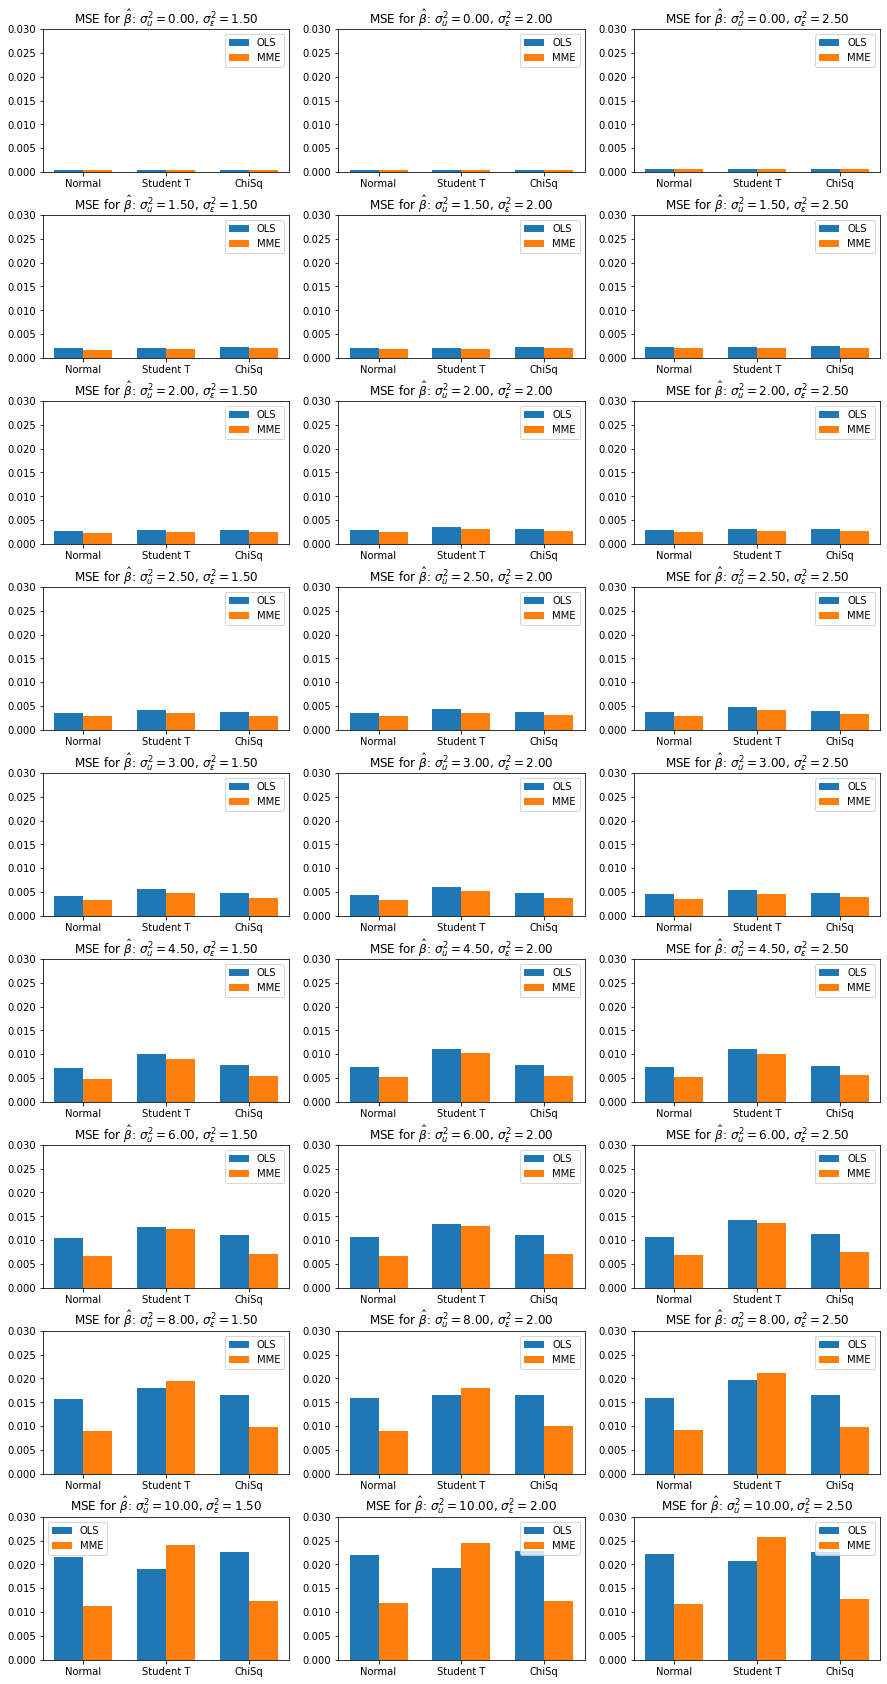

In [240]:
show_plot("MSE for $\\hat{\\beta}$", [beta_dict_normal, beta_dict_t, beta_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'sqerr_ols', 'sqerr_ols_corr', 0, 0.03)

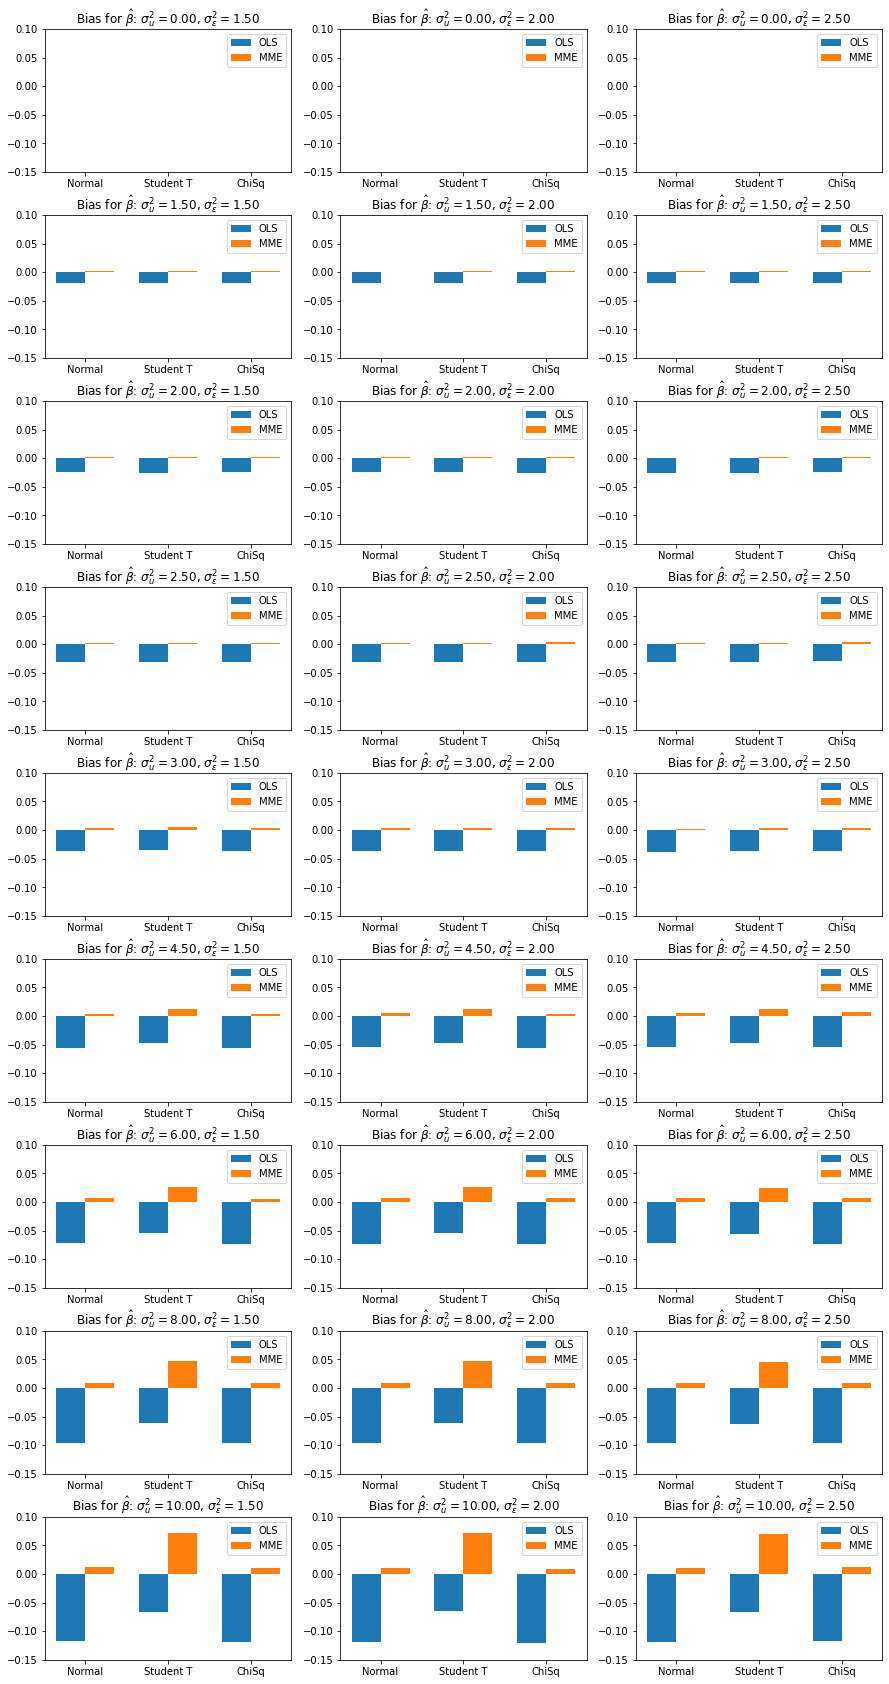

In [241]:
show_plot("Bias for $\\hat{\\beta}$", [beta_dict_normal, beta_dict_t, beta_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr', -0.15, 0.1)

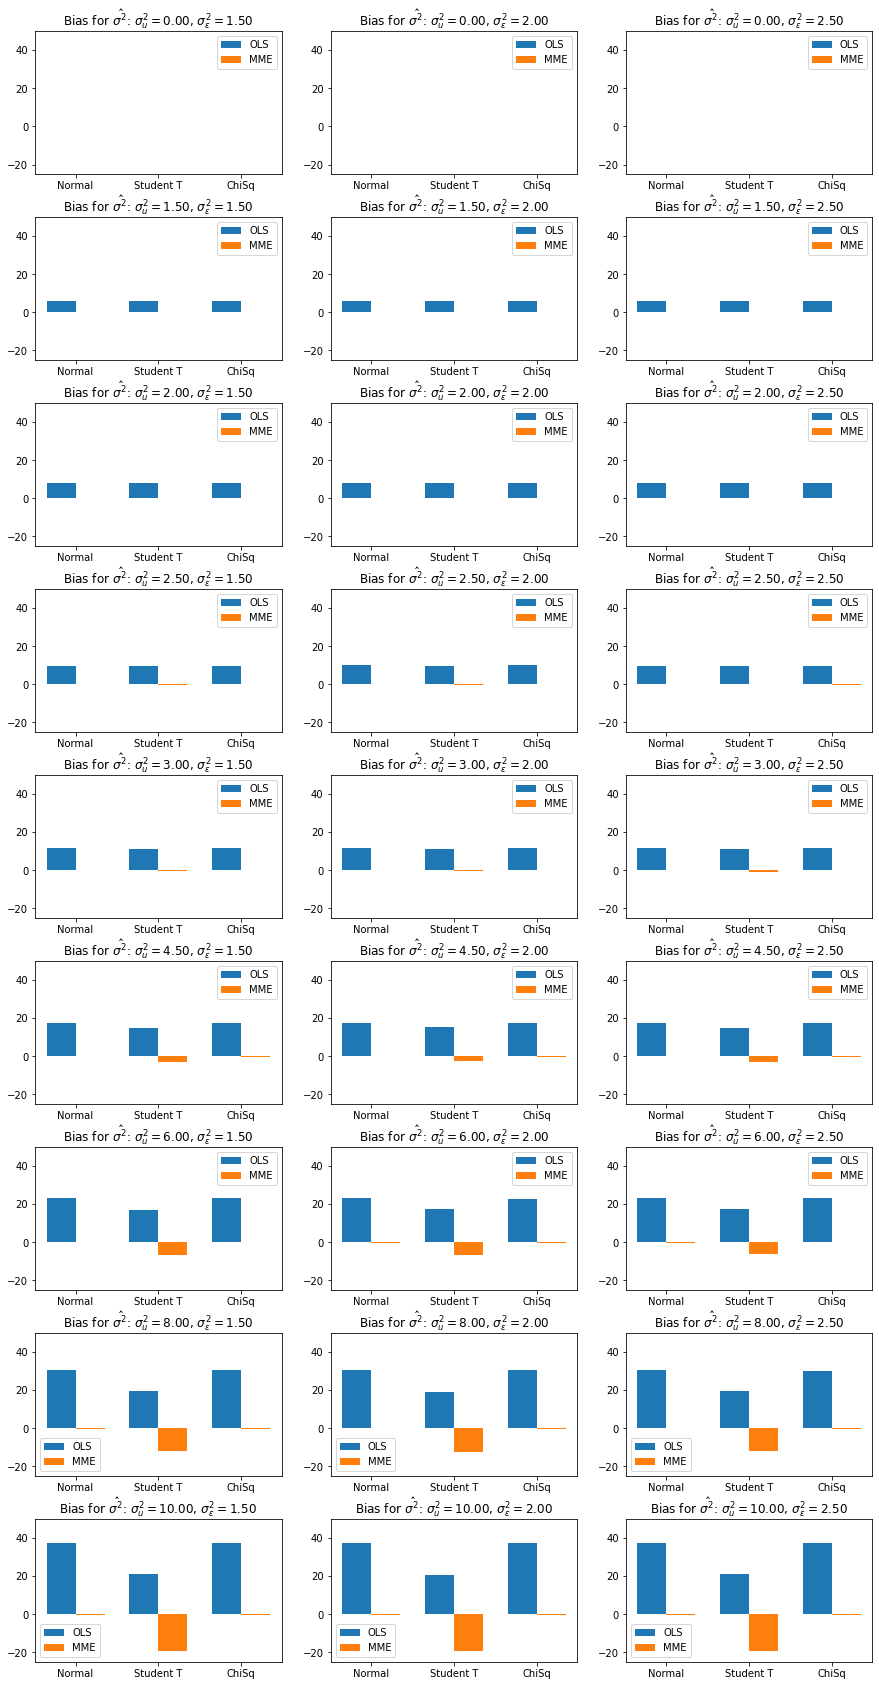

In [242]:
show_plot("Bias for $\\hat{\\sigma^2}$", [sigma_dict_normal, sigma_dict_t, sigma_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr_v2', -25, 50.0)

Special property of assuming normal errors: Maximum likelihood estimation is exactly the same as OLS